### Otimização - AMPL

Teste 1 (Otimização)

In [5]:

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i in ['2020', '2021']:  # Apenas considerar 2020 e 2021
        iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}/{arq}'):
            ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)
    else:
        os.makedirs(f'{dir}')
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################
def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])  # (dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')

    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve()

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'  # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################

# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano = '2020'  # Começar a partir de 2020
iema_ampl = iema[ano][1]
for i in ['2020', '2021']:
    if str(int(i) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i) + 1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
            if os.path.exists(dir2):
                if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                    ampl_model(iema_ampl, ons_ampl)
            else:
                os.makedirs(dir2)
                ampl_model(iema_ampl, ons_ampl)

Teste 2 (Otimização)

In [58]:
# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i in ['2020', '2021']:  # Apenas considerar 2020 e 2021
        iema[i] = pd.read_excel(os.path.join(dir, i, f'IEMA {i}.xlsx'), sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if not os.path.exists(dir):
        os.makedirs(dir)
    if not os.path.isfile(os.path.join(dir, arq)):
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(os.path.join(dir, arq), index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalentes ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = os.path.join('G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas', ons_usinas[i][j], 'Dados de Geração')
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = [i for i in os.listdir(dir) if os.path.isdir(os.path.join(dir, i)) and i != 'desktop.ini']

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################
def ampl_model(iema_ampl, ons_ampl):
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')

    ampl_instance.set['intervalos'] = range(len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt
    ampl_instance.solve()

    # Verificar se a solução foi encontrada
    if ampl_instance.getObjective("MSE").value() is not None:
        alfa = ampl_instance.getVariable("alfa").value()
        beta = ampl_instance.getVariable("beta").value()
        gamma = ampl_instance.getVariable("gamma").value()
        omega = ampl_instance.getVariable("omega").value()
        mi = ampl_instance.getVariable("mi").value()

        tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
        tab.to_csv(os.path.join(dir2, f'{list(ons_ampl["Usina"])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'), index=False)
    else:
        print("Erro na solução do modelo AMPL")

    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU

###############################################################################################################################

# Código para somar os dados de emissão IEMA (considerar apenas 2020 e 2021 para regressão)
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano_inicial = '2020'
iema_ampl = iema[ano_inicial][1]

for ano in ['2020', '2021']:
    if str(int(ano) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(ano) + 1)][1], how='outer', on='Usina', suffixes=(f'_{ano}', f'_{str(int(ano) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{ano}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(ano) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(os.path.join(dir, i, 'Dados de Geração', '*.csv'))
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = os.path.join(dir, i, 'Coeficientes', 'AMPL', 'Dados Concatenados')
            if not os.path.exists(dir2):
                os.makedirs(dir2)
            ampl_model(iema_ampl, ons_ampl)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

Teste 1 (Resultados)

In [66]:
# Diretório onde estão os coeficientes e dados de 2022
dir_coef = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados'
dir_2022 = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'

# Função para carregar os coeficientes da usina
def carregar_coeficientes(usina):
    dir_coef_usina = dir_coef.format(usina=usina)
    coeficientes = pd.read_csv(os.path.join(dir_coef_usina, f'{usina}_MSE_MW_com_zeros.csv'))
    return coeficientes

# Função para calcular a emissão com base nos coeficientes e dados de geração
def calcular_emissao(coeficientes, dados_geracao):
    alfa = coeficientes.loc[coeficientes['Coeficientes'] == 'Alfa', 'Valores'].values[0]
    beta = coeficientes.loc[coeficientes['Coeficientes'] == 'Beta', 'Valores'].values[0]
    gamma = coeficientes.loc[coeficientes['Coeficientes'] == 'Gamma', 'Valores'].values[0]
    omega = coeficientes.loc[coeficientes['Coeficientes'] == 'Omega', 'Valores'].values[0]
    mi = coeficientes.loc[coeficientes['Coeficientes'] == 'Mi', 'Valores'].values[0]

    dados_geracao['Emissao Calculada'] = alfa * dados_geracao['Geração'] ** 2 + beta * dados_geracao['Geração'] + gamma + omega * np.exp(mi * dados_geracao['Geração'])
    return dados_geracao

# Função para comparar com dados reais
def comparar_emissao(usina, coeficientes):
    # Carregar dados de emissão real
    dados_real = pd.read_excel(os.path.join(dir_2022, f'IEMA 2022.xlsx'), sheet_name='Emissão')
    dados_real = dados_real[dados_real['Usina'] == usina]

    # Carregar dados de geração
    arquivos_geracao = glob.glob(os.path.join('G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas', usina, 'Dados de Geração', '*.csv'))
    dados_geracao = pd.concat(map(pd.read_csv, arquivos_geracao))
    
    # Calcular emissão usando os coeficientes
    dados_geracao = calcular_emissao(coeficientes, dados_geracao)
    
    # Comparar com dados reais
    dados_real = dados_real[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)']]
    dados_comparacao = pd.merge(dados_real, dados_geracao[['Usina', 'Emissao Calculada']], on='Usina', how='inner')
    dados_comparacao['Erro'] = dados_comparacao['Gases Emitidos (MIL TONELADAS DE CO2e)'] - dados_comparacao['Emissao Calculada']
    
    print(dados_comparacao[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)', 'Emissao Calculada', 'Erro']])

# Selecionar a usina para comparação
usina_selecionada = input("Digite o nome da usina para comparar: ")

# Carregar coeficientes e comparar
coeficientes = carregar_coeficientes(usina_selecionada)
comparar_emissao(usina_selecionada, coeficientes)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Seu\\Caminho\\Para\\Coeficientes\\AMPL\\Dados Concatenados\\coeficientes.csv'

Teste 3 (Otimização)

In [67]:
# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

# Carregar dados apenas para 2020 e 2021
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i in ['2020', '2021']:  # Apenas considerar 2020 e 2021
        iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}/{arq}'):
            ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)
    else:
        os.makedirs(f'{dir}')
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################
def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])  # (dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')

    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve()

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'  # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################

# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano = '2020'  # Começar a partir de 2020
iema_ampl = iema[ano][1]
for i in ['2020', '2021']:
    if str(int(i) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i) + 1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para tratar dados de 2022
dir_2022 = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'
iema_2022 = pd.read_excel(f'{dir_2022}\\IEMA 2022.xlsx', sheet_name=1)  # Supondo que os dados de emissão estão na segunda aba
iema_2022.replace(np.nan, 0, inplace=True)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
            if os.path.exists(dir2):
                if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                    ampl_model(iema_ampl, ons_ampl)
            else:
                os.makedirs(dir2)
                ampl_model(iema_ampl, ons_ampl)

Teste 2 (Resultados)

In [78]:
# Função para calcular a emissão usando a fórmula dos coeficientes
def calcular_emissao(PG, alfa, beta, gamma, omega, mi):
    return (alfa * PG**2) + (beta * PG) + gamma + (omega * np.exp(mi * PG))

# Diretório dos dados IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'

# Carregar e concatenar os dados de emissão do IEMA para 2022
arquivos_iema = glob.glob(f'{dir_iema}\\*.xlsx')
iema_emi_2022 = pd.concat(
    [pd.read_excel(f, sheet_name=1)[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)']] for f in arquivos_iema],
    ignore_index=True
).groupby('Usina', as_index=False).sum()

print("Dados de emissão do IEMA carregados:")
print(iema_emi_2022.head())
print("\n")

# Diretório dos coeficientes e dados de geração
dir_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

# Variáveis para seleção dos coeficientes
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU

# Listar usinas disponíveis
usinas = [d for d in os.listdir(dir_geracao) if os.path.isdir(os.path.join(dir_geracao, d))]
print("Usinas disponíveis:")
for idx, usina in enumerate(usinas):
    print(f"{idx + 1}. {usina}")

# Selecionar a usina por nome
while True:
    usina_selecionada = input("Digite o nome da usina (por exemplo, 'Aparecida'): ")
    if usina_selecionada in usinas:
        print(f'Usina selecionada: {usina_selecionada}')
        break
    else:
        print("Nome da usina inválido. Tente novamente.")

# Carregar os coeficientes calculados
coef_dir = f'{dir_geracao}\\{usina_selecionada}\\Coeficientes\\AMPL\\Dados Concatenados'
coef_file = glob.glob(f'{coef_dir}\\*_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
coef_data = pd.read_csv(coef_file)

# Extrair coeficientes
alfa = coef_data.loc[coef_data['Coeficientes'] == 'Alfa', 'Valores'].values[0]
beta = coef_data.loc[coef_data['Coeficientes'] == 'Beta', 'Valores'].values[0]
gamma = coef_data.loc[coef_data['Coeficientes'] == 'Gamma', 'Valores'].values[0]
omega = coef_data.loc[coef_data['Coeficientes'] == 'Omega', 'Valores'].values[0]
mi = coef_data.loc[coef_data['Coeficientes'] == 'Mi', 'Valores'].values[0]

print(f'Alfa: {alfa}, Beta: {beta}, Gamma: {gamma}, Omega: {omega}, Mi: {mi}')
print("\n")

# Carregar os dados de geração para 2022
geracao_dir = f'{dir_geracao}\\{usina_selecionada}\\Dados de Geração'
files = glob.glob(f'{geracao_dir}\\*.csv')

if not files:
    print("Nenhum arquivo de geração encontrado para a usina selecionada.")
else:
    ons_2022 = pd.concat(map(pd.read_csv, files), ignore_index=True)
    print("Dados de geração carregados:")
    print(ons_2022.head())
    print("\n")

    # Verificar e garantir que a coluna 'Geração' esteja no formato numérico
    ons_2022['Geração'] = pd.to_numeric(ons_2022['Geração'], errors='coerce')

    # Preencher valores ausentes ou NaNs com zero
    ons_2022['Geração'].fillna(0, inplace=True)

    print("Dados de geração para cálculo:")
    print(ons_2022[['Geração']].describe())
    print("\n")

    # Calcular a emissão usando os coeficientes
    ons_2022['Emissao Calculada'] = calcular_emissao(ons_2022['Geração'], alfa, beta, gamma, omega, mi)
    print("Emissão calculada:")
    print(ons_2022[['Geração', 'Emissao Calculada']].head())
    print("\n")

    # Agregar a emissão total para comparação
    emissao_calculada_total = ons_2022['Emissao Calculada'].sum() / 1000  # Ajuste a conversão se necessário
    print(f'Emissão Calculada Total (MIL TONELADAS): {emissao_calculada_total}')

    # Obter a emissão do IEMA
    emisao_iema_total = iema_emi_2022.loc[iema_emi_2022['Usina'] == usina_selecionada, 'Gases Emitidos (MIL TONELADAS DE CO2e)']
    if not emisao_iema_total.empty:
        emisao_iema_total = emisao_iema_total.values[0]
        print(f'\nUsina: {usina_selecionada}')
        print(f'Emissão IEMA (2022): {emisao_iema_total} MIL TONELADAS')
        print(f'Emissão Calculada: {emissao_calculada_total} MIL TONELADAS')

        # Calcular o erro percentual
        erro = (abs(emissao_calculada_total - emisao_iema_total) / emisao_iema_total) * 100
        print(f'Erro Percentual: {erro:.2f}%')
    else:
        print('Dados de emissão do IEMA não encontrados para esta usina.')

Dados de emissão do IEMA carregados:
                Usina  Gases Emitidos (MIL TONELADAS DE CO2e)
0           Aparecida                                     379
1           Araucária                                     106
2  Baixada Fluminense                                     269
3      Barra Bonita I                                       6
4        Candiota III                                    2368


Usinas disponíveis:
1. Termorio
2. Potiguar III
3. Termoceará
4. Ibirité
5. Maranhão 3
6. Candiota III
7. Termomacaé
8. Nova Piratininga
9. Geramar I
10. Potiguar
11. Canoas
12. Petrolina
13. Fortaleza
14. Aparecida
15. Palmeiras de Goiás
16. U-50
17. Ponta Negra
18. Termocabo
19. Tambaqui
20. Termocamaçari
21. Viana
22. Termoparaíba
23. Porto de Sergipe I
24. Mauá 3
25. Cristiano Rocha
26. Maracanaú I
27. Santana
28. Global I
29. Porto do Itaqui
30. Araucária
31. Luiz O. R. Melo
32. Goiânia II
33. Cubatão
34. Santa Rita
35. Termomanaus
36. Geramar II
37. Parnaíba IV
38. Porto do Pe

C:\Users\Yuri_\AppData\Local\Temp\ipykernel_10464\1418840608.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ons_2022['Geração'].fillna(0, inplace=True)


Teste 2 (Resultados)

In [49]:
# Função para calcular a emissão usando a fórmula dos coeficientes
def calcular_emissao(PG, alfa, beta, gamma, omega, mi):
    # Usar a fórmula com parênteses para maior clareza
    return (alfa * PG**2) + (beta * PG) + gamma + (omega * np.exp(mi * PG))

# Diretório dos dados IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'

# Carregar e concatenar os dados de emissão do IEMA para 2022
arquivos_iema = glob.glob(f'{dir_iema}\\*.xlsx')
iema_emi_2022 = pd.concat(
    [pd.read_excel(f, sheet_name=1)[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)']] for f in arquivos_iema],
    ignore_index=True
)

# Agregar os dados para cada usina
iema_emi_2022 = iema_emi_2022.groupby('Usina', as_index=False).sum()

print("Dados de emissão do IEMA carregados:")
print(iema_emi_2022.head())
print("\n")

# Diretório dos coeficientes e dados de geração
dir_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

# Listar usinas disponíveis
usinas = [d for d in os.listdir(dir_geracao) if os.path.isdir(os.path.join(dir_geracao, d))]
print("Usinas disponíveis:")
for idx, usina in enumerate(usinas):
    print(f"{idx + 1}. {usina}")

# Selecionar a usina por nome
while True:
    usina_selecionada = input("Digite o nome da usina (por exemplo, 'Aparecida'): ")
    if usina_selecionada in usinas:
        print(f'Usina selecionada: {usina_selecionada}')
        break
    else:
        print("Nome da usina inválido. Tente novamente.")

# Carregar os coeficientes calculados
coef_dir = f'{dir_geracao}\\{usina_selecionada}\\Coeficientes\\AMPL\\Dados Concatenados'
coef_files = glob.glob(f'{coef_dir}\\*.csv')

if not coef_files:
    print(f"Nenhum arquivo de coeficientes encontrado para a usina {usina_selecionada}.")
else:
    coef_file = coef_files[0]  # Assumir que há apenas um arquivo de coeficientes por usina
    coef_data = pd.read_csv(coef_file)
    print("Coeficientes carregados:")
    print(coef_data)

    alfa = coef_data.loc[coef_data['Coeficientes'] == 'Alfa', 'Valores'].values[0]
    beta = coef_data.loc[coef_data['Coeficientes'] == 'Beta', 'Valores'].values[0]
    gamma = coef_data.loc[coef_data['Coeficientes'] == 'Gamma', 'Valores'].values[0]
    omega = coef_data.loc[coef_data['Coeficientes'] == 'Omega', 'Valores'].values[0]
    mi = coef_data.loc[coef_data['Coeficientes'] == 'Mi', 'Valores'].values[0]

    print(f'Alfa: {alfa}')
    print(f'Beta: {beta}')
    print(f'Gamma: {gamma}')
    print(f'Omega: {omega}')
    print(f'Mi: {mi}')
    print("\n")

# Carregar os dados de geração para 2022
geracao_dir = f'{dir_geracao}\\{usina_selecionada}\\Dados de Geração'
files = glob.glob(f'{geracao_dir}\\*.csv')

if not files:
    print("Nenhum arquivo de geração encontrado para a usina selecionada.")
else:
    ons_2022 = pd.concat(map(pd.read_csv, files), ignore_index=True)
    print("Dados de geração carregados:")
    print(ons_2022.head())
    print("\n")

    # Remover registros com geração zero
    ons_2022 = ons_2022[ons_2022['Geração'] != 0]

    # Verificar os dados de entrada antes de calcular
    print("Dados de geração para cálculo:")
    print(ons_2022[['Geração']].describe())
    print("\n")

    # Calcular a emissão usando os coeficientes
    ons_2022['Emissao Calculada'] = calcular_emissao(ons_2022['Geração'], alfa, beta, gamma, omega, mi)
    print("Emissão calculada:")
    print(ons_2022[['Geração', 'Emissao Calculada']].head())
    print("\n")

    # Agregar a emissão total para comparação
    emissao_calculada_total = ons_2022['Emissao Calculada'].sum() / 1000  # Ajuste a conversão se necessário
    print(f'Emissão Calculada Total (MIL TONELADAS): {emissao_calculada_total}')

    # Obter a emissão do IEMA
    emisao_iema = iema_emi_2022.loc[iema_emi_2022['Usina'] == usina_selecionada, 'Gases Emitidos (MIL TONELADAS DE CO2e)']
    if not emisao_iema.empty:
        emisao_iema_total = emisao_iema.values[0]
        print(f'\nUsina: {usina_selecionada}')
        print(f'Emissão IEMA (2022): {emisao_iema_total} MIL TONELADAS')
        print(f'Emissão Calculada: {emissao_calculada_total} MIL TONELADAS')  # As emissões calculadas já estão em MIL TONELADAS
    else:
        print('Dados de emissão do IEMA não encontrados para esta usina.')

Dados de emissão do IEMA carregados:
                Usina  Gases Emitidos (MIL TONELADAS DE CO2e)
0           Aparecida                                     379
1           Araucária                                     106
2  Baixada Fluminense                                     269
3      Barra Bonita I                                       6
4        Candiota III                                    2368


Usinas disponíveis:
1. Termorio
2. Potiguar III
3. Termoceará
4. Ibirité
5. Maranhão 3
6. Candiota III
7. Termomacaé
8. Nova Piratininga
9. Geramar I
10. Potiguar
11. Canoas
12. Petrolina
13. Fortaleza
14. Aparecida
15. Palmeiras de Goiás
16. U-50
17. Ponta Negra
18. Termocabo
19. Tambaqui
20. Termocamaçari
21. Viana
22. Termoparaíba
23. Porto de Sergipe I
24. Mauá 3
25. Cristiano Rocha
26. Maracanaú I
27. Santana
28. Global I
29. Porto do Itaqui
30. Araucária
31. Luiz O. R. Melo
32. Goiânia II
33. Cubatão
34. Santa Rita
35. Termomanaus
36. Geramar II
37. Parnaíba IV
38. Porto do Pe

Teste 3 Resultados

Dados de emissão do IEMA carregados:
                Usina  Gases Emitidos (MIL TONELADAS DE CO2e)
0           Aparecida                                     379
1           Araucária                                     106
2  Baixada Fluminense                                     269
3      Barra Bonita I                                       6
4        Candiota III                                    2368


Usinas disponíveis:
1. Termorio
2. Potiguar III
3. Termoceará
4. Ibirité
5. Maranhão 3
6. Candiota III
7. Termomacaé
8. Nova Piratininga
9. Geramar I
10. Potiguar
11. Canoas
12. Petrolina
13. Fortaleza
14. Aparecida
15. Palmeiras de Goiás
16. U-50
17. Ponta Negra
18. Termocabo
19. Tambaqui
20. Termocamaçari
21. Viana
22. Termoparaíba
23. Porto de Sergipe I
24. Mauá 3
25. Cristiano Rocha
26. Maracanaú I
27. Santana
28. Global I
29. Porto do Itaqui
30. Araucária
31. Luiz O. R. Melo
32. Goiânia II
33. Cubatão
34. Santa Rita
35. Termomanaus
36. Geramar II
37. Parnaíba IV
38. Porto do Pe

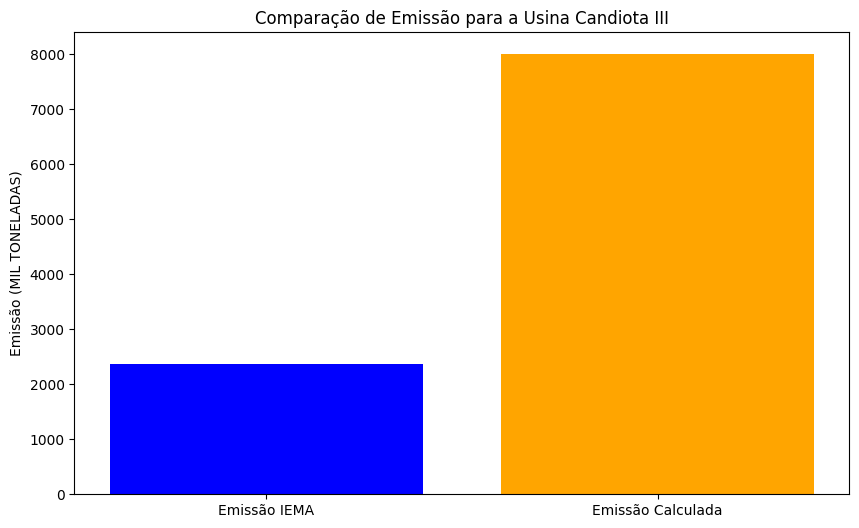

In [52]:
# Função para calcular a emissão usando a fórmula dos coeficientes
def calcular_emissao(PG, alfa, beta, gamma, omega, mi):
    # Usar a fórmula com parênteses para maior clareza
    return (alfa * PG**2) + (beta * PG) + gamma + (omega * np.exp(mi * PG))

# Diretório dos dados IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'

# Carregar e concatenar os dados de emissão do IEMA para 2022
arquivos_iema = glob.glob(f'{dir_iema}\\*.xlsx')
iema_emi_2022 = pd.concat(
    [pd.read_excel(f, sheet_name=1)[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)']] for f in arquivos_iema],
    ignore_index=True
)

# Agregar os dados para cada usina
iema_emi_2022 = iema_emi_2022.groupby('Usina', as_index=False).sum()

print("Dados de emissão do IEMA carregados:")
print(iema_emi_2022.head())
print("\n")

# Diretório dos coeficientes e dados de geração
dir_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

# Listar usinas disponíveis
usinas = [d for d in os.listdir(dir_geracao) if os.path.isdir(os.path.join(dir_geracao, d))]
print("Usinas disponíveis:")
for idx, usina in enumerate(usinas):
    print(f"{idx + 1}. {usina}")

# Selecionar a usina por nome
while True:
    usina_selecionada = input("Digite o nome da usina (por exemplo, 'Aparecida'): ")
    if usina_selecionada in usinas:
        print(f'Usina selecionada: {usina_selecionada}')
        break
    else:
        print("Nome da usina inválido. Tente novamente.")

# Carregar os coeficientes calculados
coef_dir = f'{dir_geracao}\\{usina_selecionada}\\Coeficientes\\AMPL\\Dados Concatenados'
coef_files = glob.glob(f'{coef_dir}\\*.csv')

if not coef_files:
    print(f"Nenhum arquivo de coeficientes encontrado para a usina {usina_selecionada}.")
else:
    coef_file = coef_files[0]  # Assumir que há apenas um arquivo de coeficientes por usina
    coef_data = pd.read_csv(coef_file)
    print("Coeficientes carregados:")
    print(coef_data)

    alfa = coef_data.loc[coef_data['Coeficientes'] == 'Alfa', 'Valores'].values[0]
    beta = coef_data.loc[coef_data['Coeficientes'] == 'Beta', 'Valores'].values[0]
    gamma = coef_data.loc[coef_data['Coeficientes'] == 'Gamma', 'Valores'].values[0]
    omega = coef_data.loc[coef_data['Coeficientes'] == 'Omega', 'Valores'].values[0]
    mi = coef_data.loc[coef_data['Coeficientes'] == 'Mi', 'Valores'].values[0]

    print(f'Alfa: {alfa}')
    print(f'Beta: {beta}')
    print(f'Gamma: {gamma}')
    print(f'Omega: {omega}')
    print(f'Mi: {mi}')
    print("\n")

# Carregar os dados de geração para 2022
geracao_dir = f'{dir_geracao}\\{usina_selecionada}\\Dados de Geração'
files = glob.glob(f'{geracao_dir}\\*.csv')

if not files:
    print("Nenhum arquivo de geração encontrado para a usina selecionada.")
else:
    ons_2022 = pd.concat(map(pd.read_csv, files), ignore_index=True)
    print("Dados de geração carregados:")
    print(ons_2022.head())
    print("\n")

    # Remover registros com geração zero
    ons_2022 = ons_2022[ons_2022['Geração'] != 0]

    # Verificar os dados de entrada antes de calcular
    print("Dados de geração para cálculo:")
    print(ons_2022[['Geração']].describe())
    print("\n")

    # Calcular a emissão usando os coeficientes
    ons_2022['Emissao Calculada'] = calcular_emissao(ons_2022['Geração'], alfa, beta, gamma, omega, mi)
    print("Emissão calculada:")
    print(ons_2022[['Geração', 'Emissao Calculada']].head())
    print("\n")

    # Agregar a emissão total para comparação
    emissao_calculada_total = ons_2022['Emissao Calculada'].sum() / 1000  # Ajuste a conversão se necessário
    print(f'Emissão Calculada Total (MIL TONELADAS): {emissao_calculada_total}')

    # Obter a emissão do IEMA
    emisao_iema = iema_emi_2022.loc[iema_emi_2022['Usina'] == usina_selecionada, 'Gases Emitidos (MIL TONELADAS DE CO2e)']
    if not emisao_iema.empty:
        emisao_iema_total = emisao_iema.values[0]
        print(f'\nUsina: {usina_selecionada}')
        print(f'Emissão IEMA (2022): {emisao_iema_total} MIL TONELADAS')
        print(f'Emissão Calculada: {emissao_calculada_total} MIL TONELADAS')  # As emissões calculadas já estão em MIL TONELADAS

        # Calcular o erro percentual
        erro_percentual = ((emissao_calculada_total - emisao_iema_total) / emisao_iema_total) * 100
        print(f'Erro Percentual: {erro_percentual:.2f}%')

        # Plotar gráfico de comparação
        plt.figure(figsize=(10, 6))
        plt.bar(['Emissão IEMA', 'Emissão Calculada'], [emisao_iema_total, emissao_calculada_total], color=['blue', 'orange'])
        plt.ylabel('Emissão (MIL TONELADAS)')
        plt.title(f'Comparação de Emissão para a Usina {usina_selecionada}')
        plt.show()
        
    else:
        print('Dados de emissão do IEMA não encontrados para esta usina.')

## Gráficos

Validação da Regressão Teste 1

In [61]:
# DETERMINAÇÃO DAS TABELAS DA ONS

dir = "G:\\Meu Drive\\Dissertação Yuri\\Dados ONS"

ons = {}
ons_usinas = {}

# Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i not in ['2020', '2021']:
        continue  # Considerar apenas os anos 2020 e 2021
    if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
        ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter=";")
    else:
        ons[i] = None

# Concatenar e armazenar os dados disponibilizados de forma mensal
for i in ons.keys():
    tab_temp = []
    if ons[i] is None:
        for j in range(1, 13):
            if os.path.isfile(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv'):
                tab_temp.append(pd.read_csv(f'{dir}\\{i}\\GERACAO_USINA-2_{i}_{j}.csv', delimiter=";"))
        if tab_temp:
            ons[str(i)] = pd.concat(tab_temp)
    del tab_temp

    # Separação em usinas térmicas
    ons[i] = ons[i].loc[ons[i]['nom_tipousina'] == 'TÉRMICA']
    ons_usinas[i] = list(set(ons[i]['nom_usina'].values.tolist()))

    # Remover colunas desnecessárias
    ons[i] = ons[i].drop(columns=['id_subsistema', 'nom_subsistema', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'ceg'])

    # Trocar o nome das colunas restantes
    ons[i] = ons[i].rename(columns={'din_instante': 'Dia-Hora', 'id_estado': 'Estado', 'nom_tipocombustivel': 'Combustível', 'nom_usina': 'Usina', 'val_geracao': 'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i not in ['2020', '2021']:
        continue  # Considerar apenas os anos 2020 e 2021
    iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}/{arq}'):
            ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)
    else:
        os.makedirs(dir)
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################

def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])  # (dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2; 
    ''')

    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve()

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl['Usina'])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'  # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################

# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema[ano][1]
for i in iema.keys():
    if str(int(i) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i) + 1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
            if os.path.exists(dir2):
                if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                    ampl_model(iema_ampl, ons_ampl)
            else:
                os.makedirs(dir2)
                ampl_model(iema_ampl, ons_ampl)

# CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS ANOS APRESENTADOS NO IEMA

def em_sint(j, arq):
    PG = list(arq['Geração'])
    em = []

    dir2 = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Coeficientes\\AMPL\\Dados Concatenados'
    if os.path.isfile(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
        tab = pd.read_csv(f'{dir2}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')

        alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
        beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
        gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
        omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
        mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

        for k in range(len(PG)):
            em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

        data = {
            'Dia-Hora': list(arq['Dia-Hora']),
            'Combustível': list(arq['Combustível']),
            'Usina': list(arq['Usina']),
            'Emissão': em
        }

        df = pd.DataFrame(data)
        df.to_csv(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU

# TRATATIVA ESPECÍFICA PARA 2022
if '2022' in os.listdir(dir):
    # Processar dados de 2022
    ons['2022'] = pd.read_csv(glob.glob(f'{dir}\\2022\\*')[0], delimiter=";")
    tab_temp = []
    for j in range(1, 13):
        if os.path.isfile(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv'):
            tab_temp.append(pd.read_csv(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv', delimiter=";"))
    if tab_temp:
        ons['2022'] = pd.concat(tab_temp)

    ons['2022'] = ons['2022'].loc[ons['2022']['nom_tipousina'] == 'TÉRMICA']
    ons_usinas['2022'] = list(set(ons['2022']['nom_usina'].values.tolist()))
    ons['2022'] = ons['2022'].drop(columns=['id_subsistema', 'nom_subsistema', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'ceg'])
    ons['2022'] = ons['2022'].rename(columns={'din_instante': 'Dia-Hora', 'id_estado': 'Estado', 'nom_tipocombustivel': 'Combustível', 'nom_usina': 'Usina', 'val_geracao': 'Geração'})

    # Processar dados IEMA de 2022
    iema['2022'] = pd.read_excel(f'{dir_iema}\\2022\\IEMA 2022.xlsx', sheet_name=sheets)
    iema_ger_usinas['2022'] = list(iema['2022'][0]['Usina'])
    iema_emi_usinas['2022'] = list(iema['2022'][1]['Usina'])
    
    # Armazenar dados de geração para 2022
    for j in range(len(ons_usinas['2022'])):
        if ons_usinas['2022'][j] in iema_emi_usinas['2022']:
            dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas["2022"][j]}\\Dados de Geração'
            arq = f'{ons_usinas["2022"][j]}_2022.csv'
            armazenar('2022', j, dir, arq)

    # Código para concatenar os dados de geração ONS de 2022 e realizar a otimização
    for i in usinas:
        if i in ons_usinas['2022']:
            files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
            if files:
                ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
                if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
                    ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
                if list(ons_ampl['Usina'])[0] in list(iema['2022'][1]['Usina']):
                    dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
                    if os.path.exists(dir2):
                        if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                            ampl_model(iema['2022'][1], ons_ampl)
                    else:
                        os.makedirs(dir2)
                        ampl_model(iema['2022'][1], ons_ampl)

    # CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS DADOS DE 2022
    for j in range(len(usinas)):
        if usinas[j] in iema_emi_usinas['2022']:
            arq = ons['2022'].loc[ons['2022']['Usina'] == usinas[j]]
            if not arq.empty:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usinas[j]}\\Dados de Emissão (Sintético)\\AMPL\\2022'
                if os.path.exists(dir):
                    if not os.path.isfile(f'{dir}\\{usinas[j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                        em_sint(j, arq)
                else:
                    os.makedirs(dir)
                    em_sint(j, arq)


Validação Teste 2

In [62]:
# Definição da função para aplicar os coeficientes e calcular as emissões
def aplicar_regressao_2022():
    
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
    zeros = 'com_zeros'  # sem_zeros / com_zeros
    metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
    pu_mw = 'MW'  # MW / PU

    # Processar dados de 2022
    if '2022' in os.listdir(dir):
        ons['2022'] = pd.read_csv(glob.glob(f'{dir}\\2022\\*')[0], delimiter=";")
        tab_temp = []
        for j in range(1, 13):
            if os.path.isfile(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv'):
                tab_temp.append(pd.read_csv(f'{dir}\\2022\\GERACAO_USINA-2_2022_{j}.csv', delimiter=";"))
        if tab_temp:
            ons['2022'] = pd.concat(tab_temp)

        ons['2022'] = ons['2022'].loc[ons['2022']['nom_tipousina'] == 'TÉRMICA']
        ons_usinas['2022'] = list(set(ons['2022']['nom_usina'].values.tolist()))
        ons['2022'] = ons['2022'].drop(columns=['id_subsistema', 'nom_subsistema', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'ceg'])
        ons['2022'] = ons['2022'].rename(columns={'din_instante': 'Dia-Hora', 'id_estado': 'Estado', 'nom_tipocombustivel': 'Combustível', 'nom_usina': 'Usina', 'val_geracao': 'Geração'})

        # Processar dados IEMA de 2022
        iema['2022'] = pd.read_excel(f'{dir_iema}\\2022\\IEMA 2022.xlsx', sheet_name=sheets)
        iema_ger_usinas['2022'] = list(iema['2022'][0]['Usina'])
        iema_emi_usinas['2022'] = list(iema['2022'][1]['Usina'])

        # Armazenar dados de geração para 2022
        for j in range(len(ons_usinas['2022'])):
            if ons_usinas['2022'][j] in iema_emi_usinas['2022']:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas["2022"][j]}\\Dados de Geração'
                arq = f'{ons_usinas["2022"][j]}_2022.csv'
                armazenar('2022', j, dir, arq)

        # Código para concatenar os dados de geração ONS de 2022 e realizar a otimização
        for i in ons_usinas['2022']:
            files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
            if files:
                ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
                if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
                    ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
                if list(ons_ampl['Usina'])[0] in list(iema['2022'][1]['Usina']):
                    dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
                    if os.path.exists(dir2):
                        if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                            ampl_model(iema['2022'][1], ons_ampl)
                    else:
                        os.makedirs(dir2)
                        ampl_model(iema['2022'][1], ons_ampl)

        # CÓDIGO QUE CALCULA AS EMISSÕES ANUAIS DOS DADOS DE 2022
        for j in range(len(ons_usinas['2022'])):
            if ons_usinas['2022'][j] in iema_emi_usinas['2022']:
                arq = ons['2022'].loc[ons['2022']['Usina'] == ons_usinas['2022'][j]]
                if not arq.empty:
                    dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas["2022"][j]}\\Dados de Emissão (Sintético)\\AMPL\\2022'
                    if os.path.exists(dir):
                        if not os.path.isfile(f'{dir}\\{ons_usinas["2022"][j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                            # Carregar os coeficientes de 2022
                            coef_dir = f'{dir}\\{ons_usinas["2022"][j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'
                            if os.path.isfile(coef_dir):
                                tab = pd.read_csv(coef_dir)

                                alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
                                beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
                                gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
                                omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
                                mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

                                # Calcular as emissões
                                em = []
                                PG = list(arq['Geração'])
                                for k in range(len(PG)):
                                    em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

                                data = {
                                    'Dia-Hora': list(arq['Dia-Hora']),
                                    'Combustível': list(arq['Combustível']),
                                    'Usina': list(arq['Usina']),
                                    'Emissão': em
                                }

                                df = pd.DataFrame(data)
                                df.to_csv(f'{dir}\\{ons_usinas["2022"][j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)
                            else:
                                print(f'Arquivo de coeficientes não encontrado para a usina {ons_usinas["2022"][j]} em 2022.')
                    else:
                        os.makedirs(dir)
                        # Carregar os coeficientes de 2022 e calcular as emissões
                        coef_dir = f'{dir}\\{ons_usinas["2022"][j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'
                        if os.path.isfile(coef_dir):
                            tab = pd.read_csv(coef_dir)

                            alfa = tab['Valores'].loc[tab['Coeficientes'] == 'Alfa'].item()
                            beta = tab['Valores'].loc[tab['Coeficientes'] == 'Beta'].item()
                            gamma = tab['Valores'].loc[tab['Coeficientes'] == 'Gamma'].item()
                            omega = tab['Valores'].loc[tab['Coeficientes'] == 'Omega'].item()
                            mi = tab['Valores'].loc[tab['Coeficientes'] == 'Mi'].item()

                            # Calcular as emissões
                            em = []
                            PG = list(arq['Geração'])
                            for k in range(len(PG)):
                                em.append((alfa * PG[k]**2 + beta * PG[k] + gamma) + omega * np.exp(mi * PG[k]))

                            data = {
                                'Dia-Hora': list(arq['Dia-Hora']),
                                'Combustível': list(arq['Combustível']),
                                'Usina': list(arq['Usina']),
                                'Emissão': em
                            }

                            df = pd.DataFrame(data)
                            df.to_csv(f'{dir}\\{ons_usinas["2022"][j]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)
                        else:
                            print(f'Arquivo de coeficientes não encontrado para a usina {ons_usinas["2022"][j]} em 2022.')

# Chamar a função para aplicar a regressão
aplicar_regressao_2022()

Teste Resultados

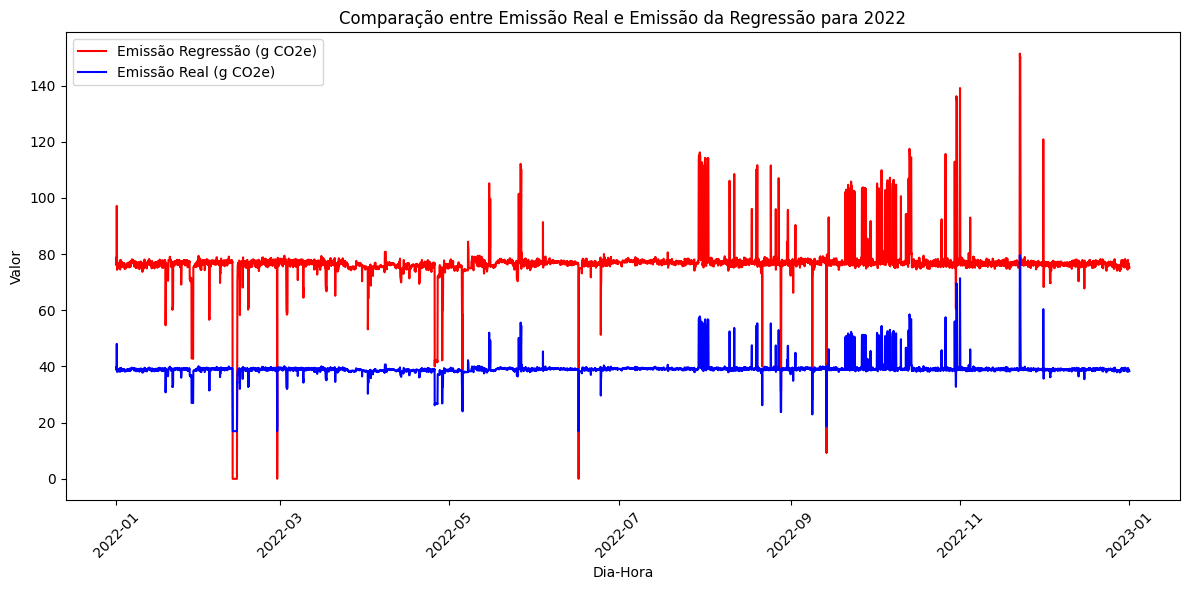

In [74]:

import matplotlib.pyplot as plt
import glob

# Definir diretórios e arquivos
dir_dados_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Aparecida\\Dados de Geração'
dir_dados_emissao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Aparecida\\Dados de Emissão (Sintético)\\AMPL\\2022'

# Substitua "NomeDaUsina" pelo nome da usina que deseja analisar
usina = 'Aparecida'
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU
zeros = 'com_zeros'  # sem_zeros / com_zeros

# Caminho dos arquivos de dados
arquivos_geracao = glob.glob(f'{dir_dados_geracao}\\*.csv')
arquivo_emissao = f'{dir_dados_emissao}\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'

# Carregar e combinar dados de geração para 2022
dados_geracao = pd.concat((pd.read_csv(f) for f in arquivos_geracao))
dados_geracao['Dia-Hora'] = pd.to_datetime(dados_geracao['Dia-Hora'])
dados_geracao = dados_geracao[dados_geracao['Dia-Hora'].dt.year == 2022]

# Carregar dados de emissão
dados_emissao = pd.read_csv(arquivo_emissao)
dados_emissao['Dia-Hora'] = pd.to_datetime(dados_emissao['Dia-Hora'])
dados_emissao = dados_emissao[dados_emissao['Dia-Hora'].dt.year == 2022]

# Mesclar os dados de geração com os dados de emissão para comparação
dados_combinados = pd.merge(dados_geracao[['Dia-Hora', 'Geração']], dados_emissao[['Dia-Hora', 'Emissão']], on='Dia-Hora')

# Plotar gráfico
plt.figure(figsize=(12, 6))
plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Geração'], label='Emissão Regressão (g CO2e)', color='red')
plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Emissão'], label='Emissão Real (g CO2e)', color='blue')
plt.xlabel('Dia-Hora')
plt.ylabel('Valor')
plt.title('Comparação entre Emissão Real e Emissão da Regressão para 2022')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir gráfico
plt.show()

Teste 5 Resultados

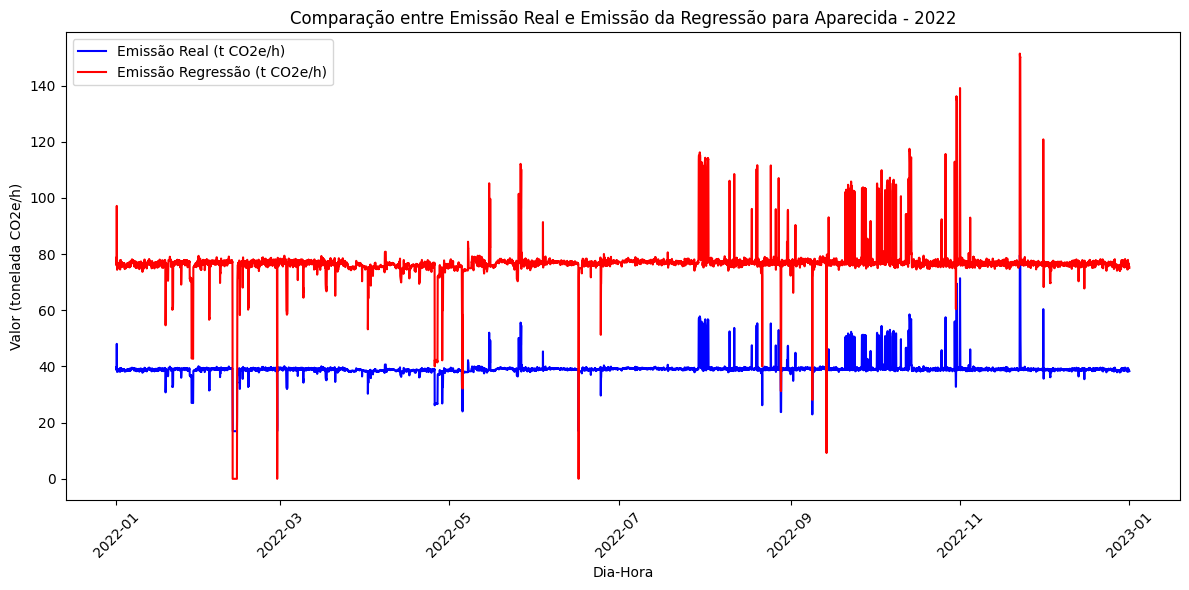

MSE (Erro Quadrático Médio): 1446.9517958625831


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def plotar_emissoes_e_mse(usina_selecionada):
    dir = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
    metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
    pu_mw = 'MW'  # MW / PU
    zeros = 'com_zeros'  # sem_zeros / com_zeros

    # Caminho dos arquivos de dados
    dir_dados_geracao = f'{dir}\\{usina_selecionada}\\Dados de Geração'
    dir_dados_emissao = f'{dir}\\{usina_selecionada}\\Dados de Emissão (Sintético)\\AMPL\\2022'
    
    # Verificar se os arquivos de dados existem
    arquivos_geracao = glob.glob(f'{dir_dados_geracao}\\*.csv')
    arquivo_emissao = f'{dir_dados_emissao}\\{usina_selecionada}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'
    
    if not arquivos_geracao or not os.path.isfile(arquivo_emissao):
        print("Arquivos necessários não encontrados.")
        return

    # Carregar dados
    dados_geracao = pd.concat(map(pd.read_csv, arquivos_geracao))
    dados_emissao = pd.read_csv(arquivo_emissao)

    # Garantir que a coluna 'Dia-Hora' está no formato datetime
    dados_geracao['Dia-Hora'] = pd.to_datetime(dados_geracao['Dia-Hora'])
    dados_emissao['Dia-Hora'] = pd.to_datetime(dados_emissao['Dia-Hora'])

    # Filtrar dados para o ano de 2022
    dados_geracao = dados_geracao[dados_geracao['Dia-Hora'].dt.year == 2022]
    dados_emissao = dados_emissao[dados_emissao['Dia-Hora'].dt.year == 2022]

    # Mesclar os dados de geração com os dados de emissão para comparação
    dados_combinados = pd.merge(dados_geracao[['Dia-Hora', 'Geração']], dados_emissao[['Dia-Hora', 'Emissão']], on='Dia-Hora')

    # Calcular o MSE
    mse = np.mean((dados_combinados['Geração'] - dados_combinados['Emissão']) ** 2)

    # Plotar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Emissão'], label='Emissão Real (t CO2e/h)', color='blue')
    plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Geração'], label='Emissão Regressão (t CO2e/h)', color='red')
    plt.xlabel('Dia-Hora')
    plt.ylabel('Valor (tonelada CO2e/h)')
    plt.title(f'Comparação entre Emissão Real e Emissão da Regressão para {usina_selecionada} - 2022')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Exibir gráfico
    plt.show()

    # Exibir MSE
    print(f'MSE (Erro Quadrático Médio): {mse}')

# Comando de input para selecionar a usina
usina_selecionada = input('Insira a usina a ser analisada: ').strip()

if usina_selecionada:
    plotar_emissoes_e_mse(usina_selecionada)
else:
    print("Nenhuma usina selecionada.")

Teste Otimização

In [92]:
# DETERMINAÇÃO DAS TABELAS DA ONS
dir = "G:\\Meu Drive\\Dissertação Yuri\\Dados ONS"

ons = {}
ons_usinas = {}

# Acessar o drive e armazenar os dados
for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i in ['2020', '2021']:  # Filtra apenas 2020 e 2021
        if len(list(set(os.listdir(f'{dir}\\{i}')) - {'desktop.ini'})) == 1:
            ons[i] = pd.read_csv(glob.glob(f'{dir}\\{i}\\*')[0], delimiter=";")
        else:
            ons[i] = None

        # Concatenar e armazenar os dados disponibilizados de forma mensal
        for j in ons.keys():
            tab_temp = []
            if ons[j] is None:
                for k in range(1, 13):
                    if os.path.isfile(f'{dir}\\{j}\\GERACAO_USINA-2_{j}_{k}.csv'):
                        tab_temp.append(pd.read_csv(f'{dir}\\{j}\\GERACAO_USINA-2_{j}_{k}.csv', delimiter=";"))
                ons[str(j)] = pd.concat(tab_temp)
            else:
                pass

            del tab_temp

            # Verificar se a coluna 'nom_tipousina' existe antes de filtrar
            if 'nom_tipousina' in ons[j].columns:
                ons[j] = ons[j].loc[ons[j]['nom_tipousina'] == 'TÉRMICA']
                ons_usinas[j] = list(set(ons[j]['nom_usina'].values.tolist()))
            else:
                ons[j] = pd.DataFrame()  # Se a coluna não existir, inicialize como um DataFrame vazio
                ons_usinas[j] = []

            # Remover colunas desnecessárias
            ons[j] = ons[j].drop(columns=['id_subsistema',
                                          'nom_subsistema',
                                          'nom_estado',
                                          'cod_modalidadeoperacao',
                                          'nom_tipousina',
                                          'ceg'], errors='ignore')

            # Trocar o nome das colunas restantes
            ons[j] = ons[j].rename(columns={'din_instante': 'Dia-Hora',
                                            'id_estado': 'Estado',
                                            'nom_tipocombustivel': 'Combustível',
                                            'nom_usina': 'Usina',
                                            'val_geracao': 'Geração'})

############################################################################################################

# DETERMINAÇÃO DAS TABELAS DA IEMA
dir = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

iema = {}
iema_emi_usinas = {}
iema_ger_usinas = {}
sheets = [0, 1]

for i in sorted(list(set(os.listdir(dir)) - {'desktop.ini'})):
    if i in ['2020', '2021']:  # Filtra apenas 2020 e 2021
        iema[i] = pd.read_excel(f'{dir}\\{i}\\IEMA {i}.xlsx', sheet_name=sheets)

for i in iema.keys():
    iema_ger_usinas[i] = list(iema[i][0]['Usina'])
    iema_emi_usinas[i] = list(iema[i][1]['Usina'])

# ARMAZENAR OS DADOS DE GERAÇÃO
def armazenar(i, j, dir, arq):
    if os.path.exists(dir):
        if not os.path.isfile(f'{dir}/{arq}'):
            ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)
    else:
        os.makedirs(f'{dir}')
        ons[i].loc[ons[i]['Usina'] == ons_usinas[i][j]].to_csv(f'{dir}/{arq}', index=False)

for i in ons:
    if i in iema_emi_usinas.keys():  # Apenas gera os dados de geração dos anos equivalente ao último relatório IEMA
        for j in range(len(ons_usinas[i])):
            if ons_usinas[i][j] in iema_emi_usinas[i]:
                dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{ons_usinas[i][j]}\\Dados de Geração'
                arq = f'{ons_usinas[i][j]}_{i}.csv'
                armazenar(i, j, dir, arq)

dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

usinas = list(set(os.listdir(f'{dir}')) - {'desktop.ini'})

############################################################################################################

# COMBINAÇÕES POSSÍVEIS DAS TERMELÉTRICAS

# Gás Natural e Ciclo Combinado
# Gás Natural e Ciclo Brayton
# Gás Natural e Motor Combustão

# Carvão Mineral e Ciclo Rankine

# Óleo Combustível e Motor Combustão

# Óleo Diesel e Motor Combustão
# Óleo Diesel e Ciclo Combinado

#############################################################################################################

def ampl_model(iema_ampl, ons_ampl):
    # Criando uma instância AMPL
    ampl_instance = AMPL()

    # Definindo parâmetros
    PG = list(ons_ampl['Geração'])  # (dividir por 100 para PU)
    E = iema_ampl['Gases Emitidos (MIL TONELADAS DE CO2e)'].loc[iema_ampl['Usina'] == ons_ampl['Usina'].iloc[0]].values[0] * 1000

    # Definindo o modelo em AMPL
    ampl_instance.eval(r'''
        set intervalos;

        param PG{intervalos};
        param E; # Emissão anual

        var alfa >= 0;
        var beta >= 0;
        var gamma >= 0;
        var omega >= 0;
        var mi >= 0;

        minimize MSE: 1/card(intervalos) * (sum{k in intervalos} (alfa*PG[k]^2 + beta*PG[k] + gamma + omega*exp(mi*PG[k])) - E)^2;
    ''')

    ampl_instance.set['intervalos'] = range(0, len(PG))
    ampl_instance.param['PG'] = PG
    ampl_instance.param['E'] = E

    # Carregando o modelo
    ampl_instance.setOption('solver', 'C:\\Users\\Yuri_\\Documents\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt')  # Instalar o solver ipopt (Disponível em https://github.com/coin-or/Ipopt)
    ampl_instance.solve()

    # Extraindo resultados
    alfa = ampl_instance.getVariable("alfa").value()
    beta = ampl_instance.getVariable("beta").value()
    gamma = ampl_instance.getVariable("gamma").value()
    omega = ampl_instance.getVariable("omega").value()
    mi = ampl_instance.getVariable("mi").value()

    # Salvando os resultados
    tab = pd.DataFrame({'Coeficientes': ['Alfa', 'Beta', 'Gamma', 'Omega', 'Mi'], 'Valores': [alfa, beta, gamma, omega, mi]})
    tab.to_csv(f'{dir2}\\{list(ons_ampl["Usina"])[0]}_{metodo_objetivo}_{pu_mw}_{zeros}.csv', index=False)

    # Limpando o modelo para disponibilizar armazenamento na memória
    del ampl_instance

###############################################################################################################################

# Parâmetros do solver
dir = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE (ALTERAR A FUNÇÃO OBJETIVO)
pu_mw = 'MW'   # MW / PU  (ALTERAR A FUNÇÃO OBJETIVO)

###############################################################################################################################

# Código para somar os dados de emissão IEMA
dir_iema = f'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'
ano = os.listdir(f'{dir_iema}')[0]
iema_ampl = iema.get(ano, [None, None])[1]
for i in iema.keys():
    if str(int(i) + 1) in iema.keys():
        iema_ampl = pd.merge(iema_ampl, iema[str(int(i) + 1)][1], how='outer', on='Usina', suffixes=(f'_{i}', f'_{str(int(i) + 1)}'))
        iema_ampl.replace(np.nan, 0, inplace=True)
        data = {'Usina': iema_ampl['Usina'].tolist(), 'Gases Emitidos (MIL TONELADAS DE CO2e)': (iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{i}'] + iema_ampl[f'Gases Emitidos (MIL TONELADAS DE CO2e)_{str(int(i) + 1)}']).tolist()}
        iema_ampl = pd.DataFrame(data)

# Código para concatenar os dados de geração ONS e realizar a otimização
for i in usinas:
    files = glob.glob(f'{dir}\\{i}\\Dados de Geração\\*.csv')
    if files:
        ons_ampl = pd.concat(map(pd.read_csv, files))  # Código para concatenar os dados de geração ONS
        if zeros == 'sem_zeros' and len(ons_ampl[ons_ampl['Geração'] == 0]) != len(ons_ampl['Geração']):
            ons_ampl = ons_ampl.loc[ons_ampl['Geração'] != 0]  # DEFINIR SE VAI SER CONSIDERADOS OS ZEROS DA GERAÇÃO
        if list(ons_ampl['Usina'])[0] in list(iema_ampl['Usina']):
            dir2 = f'{dir}\\{i}\\Coeficientes\\AMPL\\Dados Concatenados'
            if os.path.exists(dir2):
                if not os.path.isfile(f'{dir2}\\{i}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'):
                    ampl_model(iema_ampl, ons_ampl)
            else:
                os.makedirs(f'{dir2}')
                ampl_model(iema_ampl, ons_ampl)

Otimização 6

In [94]:
# Função para carregar coeficientes
def carregar_coeficientes(diretorio, usina, metodo_objetivo, pu_mw, zeros):
    arquivo_coeficientes = glob.glob(f'{diretorio}\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
    coeficientes_df = pd.read_csv(arquivo_coeficientes)
    coeficientes = {row['Coeficientes']: row['Valores'] for index, row in coeficientes_df.iterrows()}
    return coeficientes

# Função para calcular emissões
def calcular_emissao(df, coeficientes):
    alfa = coeficientes.get('Alfa', 0)
    beta = coeficientes.get('Beta', 0)
    gamma = coeficientes.get('Gamma', 0)
    omega = coeficientes.get('Omega', 0)
    mi = coeficientes.get('Mi', 0)
    
    # Aplicar a função para calcular as emissões
    df['Emissao Calculada'] = alfa * df['Geração']**2 + beta * df['Geração'] + gamma + omega * np.exp(mi * df['Geração'])
    df['Emissao Calculada (MIL TON)'] = df['Emissao Calculada'] / 1000  # Convertendo para mil toneladas de CO2
    return df

# Diretórios e parâmetros
diretorio_coeficientes = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
metodo_objetivo = 'MSE'  # Método objetivo usado
pu_mw = 'MW'  # Unidade de potência
zeros = 'com_zeros'  # Considerar geração zero

# Solicitar ao usuário o nome da usina
usinas = list(set(os.listdir(f'{diretorio_coeficientes}')) - {'desktop.ini'})
print("Usinas disponíveis:")
for usina in usinas:
    print(usina)

usina_selecionada = input("Digite o nome da usina desejada: ")

# Verificar se a usina selecionada é válida
if usina_selecionada not in usinas:
    raise ValueError(f"Usina '{usina_selecionada}' não encontrada. Verifique o nome e tente novamente.")

# Carregar coeficientes
coeficientes = carregar_coeficientes(diretorio_coeficientes, usina_selecionada, metodo_objetivo, pu_mw, zeros)

# Diretório dos dados de geração para 2022
diretorio_geracao = f'{diretorio_coeficientes}\\{usina_selecionada}\\Dados de Geração'
arquivo_geracao = glob.glob(f'{diretorio_geracao}\\*2022*.csv')[0]
dados_geracao = pd.read_csv(arquivo_geracao)

# Verificar se os dados de geração foram carregados corretamente
if dados_geracao.empty:
    raise ValueError(f"Não foi possível encontrar dados de geração para a usina {usina_selecionada} em 2022.")

# Calcular emissão
dados_geracao_com_emissao = calcular_emissao(dados_geracao, coeficientes)

# Salvar os dados com a nova coluna de emissões calculadas
arquivo_saida = f'{diretorio_geracao}\\Dados_Geracao_Com_Emissao.csv'
dados_geracao_com_emissao.to_csv(arquivo_saida, index=False)

# Exibir o resultado
emissao_total = dados_geracao_com_emissao['Emissao Calculada (MIL TON)'].sum()
print(f"Emissão total calculada para a usina {usina_selecionada}: {emissao_total:.2f} mil toneladas de CO2")

print("Processamento concluído.")

Usinas disponíveis:
Karkey 019
Ibirité
Maracanaú I
Três Lagoas
Global II
Termocamaçari
Petrolina
Santana
Santana II
Candiota III
Ponta Negra
Porto do Pecém I
Porto do Pecém II
Manauara
Prosperidade I
Karkey 013
Seropédica
Santa Cruz
Cristiano Rocha
Termopernambuco
Global I
Tambaqui
Santa Rita
Pau Ferro I
Termobahia
Juiz de Fora
Potiguar
Geramar II
Termonorte II
Cuiabá
Termomacaé
Luiz O. R. Melo
Campina Grande
Porsud I
Viana
Nova Piratininga
Viana 1
Goiânia II
Parnaíba 5
Maranhão 3
Termomanaus
Barra Bonita I
J. Lacerda C
Uruguaiana
Termonordeste
Potiguar III
Aparecida
Cubatão
Termoparaíba
Termoceará
Termonorte 1
Jaraqui
Figueira
Vale do Açú
Baixada Fluminense
Canoas
U-50
Termorio
Geramar I
Nome_da_Usina
GNA I
Povoação 1
Pampa Sul
Parnaíba IV
Suape II
Porto do Itaqui
Mauá 3
Termocabo
Araucária
Porsud II
Fortaleza
Porto de Sergipe I
Pernambuco III
Norte Fluminense
Palmeiras de Goiás


Emissão total calculada para a usina Aparecida: 282.86 mil toneladas de CO2
Processamento concluído.


Validação Teste

In [111]:
# Função para carregar coeficientes
def carregar_coeficientes(diretorio, usina, metodo_objetivo, pu_mw, zeros):
    arquivo_coeficientes = glob.glob(f'{diretorio}\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
    coeficientes_df = pd.read_csv(arquivo_coeficientes)
    coeficientes = {row['Coeficientes']: row['Valores'] for index, row in coeficientes_df.iterrows()}
    return coeficientes

# Função para calcular emissões
def calcular_emissao(df, coeficientes):
    alfa = coeficientes.get('Alfa', 0)
    beta = coeficientes.get('Beta', 0)
    gamma = coeficientes.get('Gamma', 0)
    omega = coeficientes.get('Omega', 0)
    mi = coeficientes.get('Mi', 0)
    
    # Aplicar a função para calcular as emissões
    df['Emissao Calculada'] = alfa * df['Geração']**2 + beta * df['Geração'] + gamma + omega * np.exp(mi * df['Geração'])
    df['Emissao Calculada (MIL TON)'] = df['Emissao Calculada'] / 1000  # Convertendo para mil toneladas de CO2
    return df

# Função para carregar as emissões do IEMA para 2022
def carregar_emissao_iema_2022(dir_iema, usina):
    arquivo_iema_2022 = f'{dir_iema}\\2022\\IEMA 2022.xlsx'
    iema_2022 = pd.read_excel(arquivo_iema_2022, sheet_name=1)
    if usina in iema_2022['Usina'].values:
        return iema_2022.loc[iema_2022['Usina'] == usina, 'Gases Emitidos (MIL TONELADAS DE CO2e)'].values[0]
    return None

# Diretórios e parâmetros
diretorio_coeficientes = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
metodo_objetivo = 'MSE'  # Método objetivo usado
pu_mw = 'MW'  # Unidade de potência
zeros = 'com_zeros'  # Considerar geração zero

# Diretório dos dados de emissão do IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

# Solicitar ao usuário o nome da usina
usinas = list(set(os.listdir(f'{diretorio_coeficientes}')) - {'desktop.ini'})
print("Usinas disponíveis:")
for usina in usinas:
    print(usina)

usina_selecionada = input("Digite o nome da usina desejada: ")

# Verificar se a usina selecionada é válida
if usina_selecionada not in usinas:
    raise ValueError(f"Usina '{usina_selecionada}' não encontrada. Verifique o nome e tente novamente.")

# Carregar coeficientes
coeficientes = carregar_coeficientes(diretorio_coeficientes, usina_selecionada, metodo_objetivo, pu_mw, zeros)

# Diretório dos dados de geração para 2022
diretorio_geracao = f'{diretorio_coeficientes}\\{usina_selecionada}\\Dados de Geração'
arquivo_geracao = glob.glob(f'{diretorio_geracao}\\*2022*.csv')[0]
dados_geracao = pd.read_csv(arquivo_geracao)

# Verificar se os dados de geração foram carregados corretamente
if dados_geracao.empty:
    raise ValueError(f"Não foi possível encontrar dados de geração para a usina {usina_selecionada} em 2022.")

# Calcular emissão
dados_geracao_com_emissao = calcular_emissao(dados_geracao, coeficientes)

# Carregar emissões do IEMA para 2022
emissao_iema_2022 = carregar_emissao_iema_2022(dir_iema, usina_selecionada)
if emissao_iema_2022 is None:
    raise ValueError(f"Dados de emissão do IEMA não encontrados para a usina {usina_selecionada} em 2022.")

# Calcular erro percentual
emissao_calculada_total = dados_geracao_com_emissao['Emissao Calculada (MIL TON)'].sum()
erro_percentual = abs(emissao_calculada_total - emissao_iema_2022) / emissao_iema_2022 * 100

# Salvar os dados com a nova coluna de emissões calculadas
arquivo_saida = f'{diretorio_geracao}\\Dados_Geracao_Com_Emissao.csv'
dados_geracao_com_emissao.to_csv(arquivo_saida, index=False)

# Exibir o resultado
print(f"Emissão total calculada para a usina {usina_selecionada} em 2022: {emissao_calculada_total:.2f} mil toneladas de CO2")
print(f"Emissão reportada pelo IEMA para a usina {usina_selecionada} em 2022: {emissao_iema_2022:.2f} mil toneladas de CO2")
print(f"Erro percentual: {erro_percentual:.2f}%")

print("Processamento concluído.")

Usinas disponíveis:
Karkey 019
Ibirité
Maracanaú I
Três Lagoas
Global II
Termocamaçari
Petrolina
Santana
Santana II
Candiota III
Ponta Negra
Porto do Pecém I
Porto do Pecém II
Manauara
Prosperidade I
Karkey 013
Seropédica
Santa Cruz
Cristiano Rocha
Termopernambuco
Global I
Tambaqui
Santa Rita
Pau Ferro I
Termobahia
Juiz de Fora
Potiguar
Geramar II
Termonorte II
Cuiabá
Termomacaé
Luiz O. R. Melo
Campina Grande
Porsud I
Viana
Nova Piratininga
Viana 1
Goiânia II
Parnaíba 5
Maranhão 3
Termomanaus
Barra Bonita I
J. Lacerda C
Uruguaiana
Termonordeste
Potiguar III
Aparecida
Cubatão
Termoparaíba
Termoceará
Termonorte 1
Jaraqui
Figueira
Vale do Açú
Baixada Fluminense
Canoas
U-50
Termorio
Geramar I
Nome_da_Usina
GNA I
Povoação 1
Pampa Sul
Parnaíba IV
Suape II
Porto do Itaqui
Mauá 3
Termocabo
Araucária
Porsud II
Fortaleza
Porto de Sergipe I
Pernambuco III
Norte Fluminense
Palmeiras de Goiás
Emissão total calculada para a usina Santa Cruz em 2022: 417.46 mil toneladas de CO2
Emissão reportada pelo

Validação 2

Usinas disponíveis:
Karkey 019
Ibirité
Maracanaú I
Três Lagoas
Global II
Termocamaçari
Petrolina
Santana
Santana II
Candiota III
Ponta Negra
Porto do Pecém I
Porto do Pecém II
Manauara
Prosperidade I
Karkey 013
Seropédica
Santa Cruz
Cristiano Rocha
Termopernambuco
Global I
Tambaqui
Santa Rita
Pau Ferro I
Termobahia
Juiz de Fora
Potiguar
Geramar II
Termonorte II
Cuiabá
Termomacaé
Luiz O. R. Melo
Campina Grande
Porsud I
Viana
Nova Piratininga
Viana 1
Goiânia II
Parnaíba 5
Maranhão 3
Termomanaus
Barra Bonita I
J. Lacerda C
Uruguaiana
Termonordeste
Potiguar III
Aparecida
Cubatão
Termoparaíba
Termoceará
Termonorte 1
Jaraqui
Figueira
Vale do Açú
Baixada Fluminense
Canoas
U-50
Termorio
Geramar I
Nome_da_Usina
GNA I
Povoação 1
Pampa Sul
Parnaíba IV
Suape II
Porto do Itaqui
Mauá 3
Termocabo
Araucária
Porsud II
Fortaleza
Porto de Sergipe I
Pernambuco III
Norte Fluminense
Palmeiras de Goiás
Emissão total calculada para a usina Aparecida em 2022: 282.86 mil toneladas de CO2
Emissão reportada pelo 

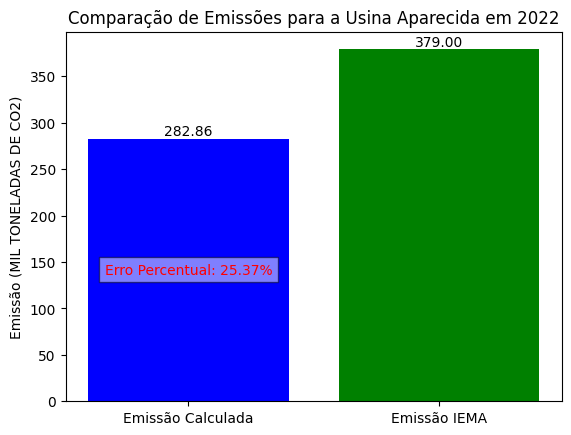

Processamento concluído.


In [113]:
# Função para carregar coeficientes
def carregar_coeficientes(diretorio, usina, metodo_objetivo, pu_mw, zeros):
    arquivo_coeficientes = glob.glob(f'{diretorio}\\{usina}\\Coeficientes\\AMPL\\Dados Concatenados\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
    coeficientes_df = pd.read_csv(arquivo_coeficientes)
    coeficientes = {row['Coeficientes']: row['Valores'] for index, row in coeficientes_df.iterrows()}
    return coeficientes

# Função para calcular emissões
def calcular_emissao(df, coeficientes):
    alfa = coeficientes.get('Alfa', 0)
    beta = coeficientes.get('Beta', 0)
    gamma = coeficientes.get('Gamma', 0)
    omega = coeficientes.get('Omega', 0)
    mi = coeficientes.get('Mi', 0)
    
    # Aplicar a função para calcular as emissões
    df['Emissao Calculada'] = alfa * df['Geração']**2 + beta * df['Geração'] + gamma + omega * np.exp(mi * df['Geração'])
    df['Emissao Calculada (MIL TON)'] = df['Emissao Calculada'] / 1000  # Convertendo para mil toneladas de CO2
    return df

# Função para carregar as emissões do IEMA para 2022
def carregar_emissao_iema_2022(dir_iema, usina):
    arquivo_iema_2022 = f'{dir_iema}\\2022\\IEMA 2022.xlsx'
    iema_2022 = pd.read_excel(arquivo_iema_2022, sheet_name=1)
    if usina in iema_2022['Usina'].values:
        return iema_2022.loc[iema_2022['Usina'] == usina, 'Gases Emitidos (MIL TONELADAS DE CO2e)'].values[0]
    return None

# Diretórios e parâmetros
diretorio_coeficientes = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'
metodo_objetivo = 'MSE'  # Método objetivo usado
pu_mw = 'MW'  # Unidade de potência
zeros = 'com_zeros'  # Considerar geração zero

# Diretório dos dados de emissão do IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA'

# Solicitar ao usuário o nome da usina
usinas = list(set(os.listdir(f'{diretorio_coeficientes}')) - {'desktop.ini'})
print("Usinas disponíveis:")
for usina in usinas:
    print(usina)

usina_selecionada = input("Digite o nome da usina desejada: ")

# Verificar se a usina selecionada é válida
if usina_selecionada not in usinas:
    raise ValueError(f"Usina '{usina_selecionada}' não encontrada. Verifique o nome e tente novamente.")

# Carregar coeficientes
coeficientes = carregar_coeficientes(diretorio_coeficientes, usina_selecionada, metodo_objetivo, pu_mw, zeros)

# Diretório dos dados de geração para 2022
diretorio_geracao = f'{diretorio_coeficientes}\\{usina_selecionada}\\Dados de Geração'
arquivo_geracao = glob.glob(f'{diretorio_geracao}\\*2022*.csv')[0]
dados_geracao = pd.read_csv(arquivo_geracao)

# Verificar se os dados de geração foram carregados corretamente
if dados_geracao.empty:
    raise ValueError(f"Não foi possível encontrar dados de geração para a usina {usina_selecionada} em 2022.")

# Calcular emissão
dados_geracao_com_emissao = calcular_emissao(dados_geracao, coeficientes)

# Carregar emissões do IEMA para 2022
emissao_iema_2022 = carregar_emissao_iema_2022(dir_iema, usina_selecionada)
if emissao_iema_2022 is None:
    raise ValueError(f"Dados de emissão do IEMA não encontrados para a usina {usina_selecionada} em 2022.")

# Calcular erro percentual
emissao_calculada_total = dados_geracao_com_emissao['Emissao Calculada (MIL TON)'].sum()
erro_percentual = abs(emissao_calculada_total - emissao_iema_2022) / emissao_iema_2022 * 100

# Salvar os dados com a nova coluna de emissões calculadas
arquivo_saida = f'{diretorio_geracao}\\Dados_Geracao_Com_Emissao.csv'
dados_geracao_com_emissao.to_csv(arquivo_saida, index=False)

# Exibir o resultado
print(f"Emissão total calculada para a usina {usina_selecionada} em 2022: {emissao_calculada_total:.2f} mil toneladas de CO2")
print(f"Emissão reportada pelo IEMA para a usina {usina_selecionada} em 2022: {emissao_iema_2022:.2f} mil toneladas de CO2")
print(f"Erro percentual: {erro_percentual:.2f}%")

# Visualização gráfica
labels = ['Emissão Calculada', 'Emissão IEMA']
valores = [emissao_calculada_total, emissao_iema_2022]

fig, ax = plt.subplots()
ax.bar(labels, valores, color=['blue', 'green'])
ax.set_ylabel('Emissão (MIL TONELADAS DE CO2)')
ax.set_title(f'Comparação de Emissões para a Usina {usina_selecionada} em 2022')

# Adicionar o erro percentual ao gráfico
for i, v in enumerate(valores):
    ax.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')
    if i == 0:
        ax.text(i, v / 2, f"Erro Percentual: {erro_percentual:.2f}%", ha='center', va='center', color='red', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

print("Processamento concluído.")

Teste 5 Resultados

In [ ]:
import matplotlib.pyplot as plt
import glob

# Definir diretórios e arquivos
dir_dados_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Aparecida\\Dados de Geração'
dir_dados_emissao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\Aparecida\\Dados de Emissão (Sintético)\\AMPL\\2022'

# Substitua "NomeDaUsina" pelo nome da usina que deseja analisar
usina = 'Aparecida'
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU
zeros = 'com_zeros'  # sem_zeros / com_zeros

# Caminho dos arquivos de dados
arquivos_geracao = glob.glob(f'{dir_dados_geracao}\\*.csv')
arquivo_emissao = f'{dir_dados_emissao}\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'

# Carregar e combinar dados de geração para 2022
dados_geracao = pd.concat((pd.read_csv(f) for f in arquivos_geracao))
dados_geracao['Dia-Hora'] = pd.to_datetime(dados_geracao['Dia-Hora'])
dados_geracao = dados_geracao[dados_geracao['Dia-Hora'].dt.year == 2022]

# Carregar dados de emissão
dados_emissao = pd.read_csv(arquivo_emissao)
dados_emissao['Dia-Hora'] = pd.to_datetime(dados_emissao['Dia-Hora'])
dados_emissao = dados_emissao[dados_emissao['Dia-Hora'].dt.year == 2022]

# Mesclar os dados de geração com os dados de emissão para comparação
dados_combinados = pd.merge(dados_geracao[['Dia-Hora', 'Geração']], dados_emissao[['Dia-Hora', 'Emissão']], on='Dia-Hora')

# Plotar gráfico
plt.figure(figsize=(12, 6))
plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Geração'], label='Emissão Regressão (g CO2e)', color='red')
plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Emissão'], label='Emissão Real (g CO2e)', color='blue')
plt.xlabel('Dia-Hora')
plt.ylabel('Valor')
plt.title('Comparação entre Emissão Real e Emissão da Regressão para 2022')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir gráfico
plt.show()

In [ ]:
# Função para calcular a emissão usando a fórmula dos coeficientes
def calcular_emissao(PG, alfa, beta, gamma, omega, mi):
    return (alfa * PG**2) + (beta * PG) + gamma + (omega * np.exp(mi * PG))

# Diretório dos dados IEMA
dir_iema = 'G:\\Meu Drive\\Dissertação Yuri\\Dados IEMA\\2022'

# Carregar e concatenar os dados de emissão do IEMA para 2022
arquivos_iema = glob.glob(f'{dir_iema}\\*.xlsx')
iema_emi_2022 = pd.concat(
    [pd.read_excel(f, sheet_name=1)[['Usina', 'Gases Emitidos (MIL TONELADAS DE CO2e)']] for f in arquivos_iema],
    ignore_index=True
).groupby('Usina', as_index=False).sum()

print("Dados de emissão do IEMA carregados:")
print(iema_emi_2022.head())
print("\n")

# Diretório dos coeficientes e dados de geração
dir_geracao = 'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas'

# Variáveis para seleção dos coeficientes
zeros = 'com_zeros'  # sem_zeros / com_zeros
metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
pu_mw = 'MW'  # MW / PU

# Listar usinas disponíveis
usinas = [d for d in os.listdir(dir_geracao) if os.path.isdir(os.path.join(dir_geracao, d))]
print("Usinas disponíveis:")
for idx, usina in enumerate(usinas):
    print(f"{idx + 1}. {usina}")

# Selecionar a usina por nome
while True:
    usina_selecionada = input("Digite o nome da usina (por exemplo, 'Aparecida'): ")
    if usina_selecionada in usinas:
        print(f'Usina selecionada: {usina_selecionada}')
        break
    else:
        print("Nome da usina inválido. Tente novamente.")

# Carregar os coeficientes calculados
coef_dir = f'{dir_geracao}\\{usina_selecionada}\\Coeficientes\\AMPL\\Dados Concatenados'
coef_file = glob.glob(f'{coef_dir}\\*_{metodo_objetivo}_{pu_mw}_{zeros}.csv')[0]
coef_data = pd.read_csv(coef_file)

# Extrair coeficientes
alfa = coef_data.loc[coef_data['Coeficientes'] == 'Alfa', 'Valores'].values[0]
beta = coef_data.loc[coef_data['Coeficientes'] == 'Beta', 'Valores'].values[0]
gamma = coef_data.loc[coef_data['Coeficientes'] == 'Gamma', 'Valores'].values[0]
omega = coef_data.loc[coef_data['Coeficientes'] == 'Omega', 'Valores'].values[0]
mi = coef_data.loc[coef_data['Coeficientes'] == 'Mi', 'Valores'].values[0]

print(f'Alfa: {alfa}, Beta: {beta}, Gamma: {gamma}, Omega: {omega}, Mi: {mi}')
print("\n")

# Carregar os dados de geração para 2022
geracao_dir = f'{dir_geracao}\\{usina_selecionada}\\Dados de Geração'
files = glob.glob(f'{geracao_dir}\\*.csv')

if not files:
    print("Nenhum arquivo de geração encontrado para a usina selecionada.")
else:
    ons_2022 = pd.concat(map(pd.read_csv, files), ignore_index=True)
    print("Dados de geração carregados:")
    print(ons_2022.head())
    print("\n")

    # Verificar e garantir que a coluna 'Geração' esteja no formato numérico
    ons_2022['Geração'] = pd.to_numeric(ons_2022['Geração'], errors='coerce')

    # Preencher valores ausentes ou NaNs com zero
    ons_2022['Geração'].fillna(0, inplace=True)

    print("Dados de geração para cálculo:")
    print(ons_2022[['Geração']].describe())
    print("\n")

    # Calcular a emissão usando os coeficientes
    ons_2022['Emissao Calculada'] = calcular_emissao(ons_2022['Geração'], alfa, beta, gamma, omega, mi)
    print("Emissão calculada:")
    print(ons_2022[['Geração', 'Emissao Calculada']].head())
    print("\n")

    # Agregar a emissão total para comparação
    emissao_calculada_total = ons_2022['Emissao Calculada'].sum() / 1000  # Ajuste a conversão se necessário
    print(f'Emissão Calculada Total (MIL TONELADAS): {emissao_calculada_total}')

    # Obter a emissão do IEMA
    emisao_iema_total = iema_emi_2022.loc[iema_emi_2022['Usina'] == usina_selecionada, 'Gases Emitidos (MIL TONELADAS DE CO2e)']
    if not emisao_iema_total.empty:
        emisao_iema_total = emisao_iema_total.values[0]
        print(f'\nUsina: {usina_selecionada}')
        print(f'Emissão IEMA (2022): {emisao_iema_total} MIL TONELADAS')
        print(f'Emissão Calculada: {emissao_calculada_total} MIL TONELADAS')

        # Calcular o erro percentual
        erro = (abs(emissao_calculada_total - emisao_iema_total) / emisao_iema_total) * 100
        print(f'Erro Percentual: {erro:.2f}%')
    else:
        print('Dados de emissão do IEMA não encontrados para esta usina.')

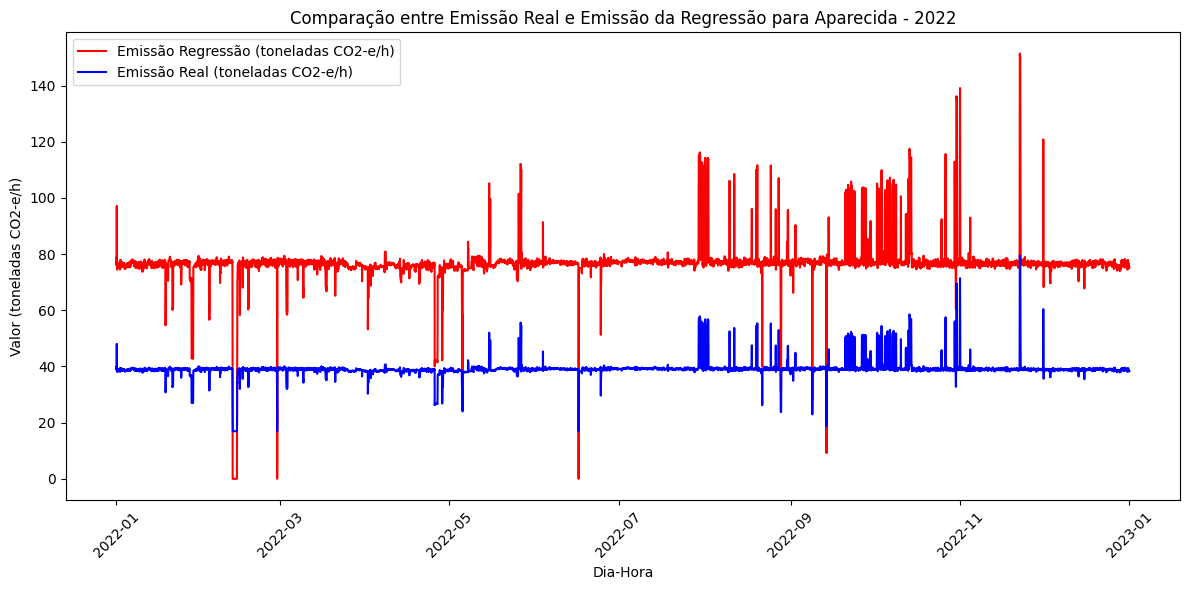

In [78]:
# Função para plotar as emissões
def plotar_emissoes(usina):
    dir_dados_geracao = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Geração'
    dir_dados_emissao = f'G:\\Meu Drive\\Dissertação Yuri\\ONS Termeletricas\\{usina}\\Dados de Emissão (Sintético)\\AMPL\\2022'

    metodo_objetivo = 'MSE'  # MSE / RMSE / MAPE
    pu_mw = 'MW'  # MW / PU
    zeros = 'com_zeros'  # sem_zeros / com_zeros

    # Caminho dos arquivos de dados
    arquivos_geracao = glob.glob(f'{dir_dados_geracao}\\*.csv')
    arquivo_emissao = f'{dir_dados_emissao}\\{usina}_{metodo_objetivo}_{pu_mw}_{zeros}.csv'

    # Verificar se os arquivos existem
    if not arquivos_geracao or not os.path.isfile(arquivo_emissao):
        print("Arquivos necessários não encontrados.")
        return

    # Carregar e combinar dados de geração para 2022
    dados_geracao = pd.concat((pd.read_csv(f) for f in arquivos_geracao))
    dados_geracao['Dia-Hora'] = pd.to_datetime(dados_geracao['Dia-Hora'])
    dados_geracao = dados_geracao[dados_geracao['Dia-Hora'].dt.year == 2022]

    # Carregar dados de emissão
    dados_emissao = pd.read_csv(arquivo_emissao)
    dados_emissao['Dia-Hora'] = pd.to_datetime(dados_emissao['Dia-Hora'])
    dados_emissao = dados_emissao[dados_emissao['Dia-Hora'].dt.year == 2022]

    # Mesclar os dados de geração com os dados de emissão para comparação
    dados_combinados = pd.merge(dados_geracao[['Dia-Hora', 'Geração']], dados_emissao[['Dia-Hora', 'Emissão']], on='Dia-Hora')

    # Plotar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Geração'], label='Emissão Regressão (toneladas CO2-e/h)', color='red')
    plt.plot(dados_combinados['Dia-Hora'], dados_combinados['Emissão'], label='Emissão Real (toneladas CO2-e/h)', color='blue')
    plt.xlabel('Dia-Hora')
    plt.ylabel('Valor (toneladas CO2-e/h)')
    plt.title(f'Comparação entre Emissão Real e Emissão da Regressão para {usina} - 2022')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Exibir gráfico
    plt.show()

# Comando de input para selecionar a usina
usina_selecionada = input('Insira o nome da usina a ser analisada: ').strip()

if usina_selecionada:
    plotar_emissoes(usina_selecionada)
else:
    print("Nenhuma usina selecionada.")